# 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
movies = pd.read_csv('./movie_inventory.csv', engine='python', encoding='CP949')
print(movies.shape)
movies.head()

(106, 32)


,item_id,contract_year,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,...,director,Genre_1,Genre_2,Genre_3,actor_1,actor_2,actor_3,contract_price,studio_score,price_class
0,I-1001,2015,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005,05-19-2005,140,PG-13,PG-13,7.5,...,George Lucas,Action,Adventure,Fantasy,Ewan McGregor,Natalie Portman,Hayden Christensen,2700,10,10
1,I-1002,2015,tt0330373,Harry Potter and the Goblet of Fire,2005,11-18-2005,157,PG-13,PG-13,7.7,...,Mike Newell,Adventure,Family,Fantasy,Eric Sykes,Timothy Spall,David Tennant,2700,10,10
2,I-1003,2015,tt0363771,"The Chronicles of Narnia: The Lion, the Witc",2005,12-09-2005,143,PG,PG,6.9,...,Andrew Adamson,Adventure,Family,Fantasy,Georgie Henley,Skandar Keynes,William Moseley,2295,10,1
3,I-1004,2015,tt0383574,Pirates of the Caribbean: Dead Man's Chest,2006,07-07-2006,151,PG-13,PG-13,7.3,...,Gore Verbinski,Action,Adventure,Fantasy,Johnny Depp,Orlando Bloom,Keira Knightley,2295,10,1
4,I-1005,2015,tt0413300,Spider-Man 3,2007,05-04-2007,139,PG-13,PG-13,6.2,...,Sam Raimi,Action,Adventure,Sci-Fi,Tobey Maguire,Kirsten Dunst,James Franco,2295,10,1


In [3]:
movies.shape

(106, 32)

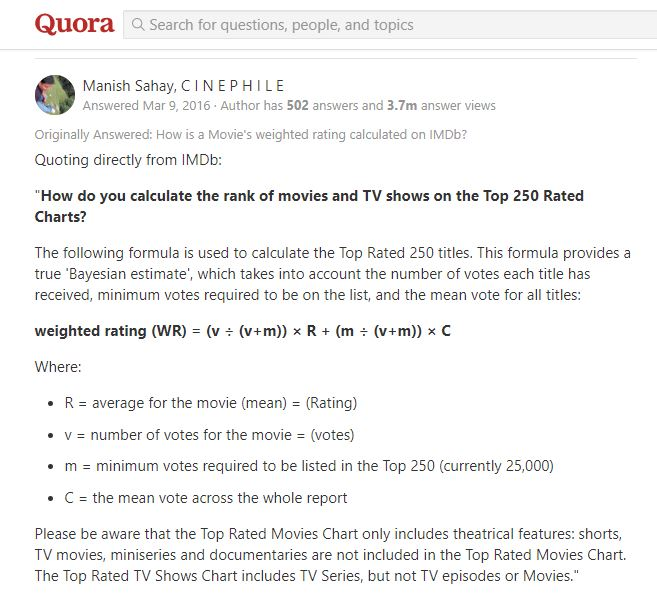

IMDB가 세운 가중평점 기준 \

가중 평점(Weighted Rating) = (v/(v+m)) * R + (m/(v+m)) * C

v: 개별 영화에 평점을 투표한 횟수 \
m : 평점을 부여하기 위한 최소 투표 횟수\ (이건 정하기 나름)
R : 개별 영화에 대한 평균 평점. \
C : 전체 영화에 대한 평균 평점 \

m은 상위 기준을 250위든, 500위든 임의로 어떻게 정하느냐에 따라 달라질 수 있습니다.
imdb 점수는 imdb 웹사이트를 이용하는 사용자들이 매긴 점수이기 때문에 리뷰를 단 사용자 수 기준으로 정했음.

In [4]:
tmp_m = movies['reviews_users'].quantile(0.89)
tmp_m

2465.750000000001

In [25]:
tmp_data = movies.copy().loc[movies['reviews_users']>=tmp_m]
tmp_data.shape

(12, 31)

In [6]:
del tmp_data

m = movies['reviews_users'].quantile(0.9)
movies = movies.loc[movies['votes']>=m]

In [7]:
movies.head()

,item_id,contract_year,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,...,director,Genre_1,Genre_2,Genre_3,actor_1,actor_2,actor_3,contract_price,studio_score,price_class
0,I-1001,2015,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005,05-19-2005,140,PG-13,PG-13,7.5,...,George Lucas,Action,Adventure,Fantasy,Ewan McGregor,Natalie Portman,Hayden Christensen,2700,10,10
1,I-1002,2015,tt0330373,Harry Potter and the Goblet of Fire,2005,11-18-2005,157,PG-13,PG-13,7.7,...,Mike Newell,Adventure,Family,Fantasy,Eric Sykes,Timothy Spall,David Tennant,2700,10,10
2,I-1003,2015,tt0363771,"The Chronicles of Narnia: The Lion, the Witc",2005,12-09-2005,143,PG,PG,6.9,...,Andrew Adamson,Adventure,Family,Fantasy,Georgie Henley,Skandar Keynes,William Moseley,2295,10,1
3,I-1004,2015,tt0383574,Pirates of the Caribbean: Dead Man's Chest,2006,07-07-2006,151,PG-13,PG-13,7.3,...,Gore Verbinski,Action,Adventure,Fantasy,Johnny Depp,Orlando Bloom,Keira Knightley,2295,10,1
4,I-1005,2015,tt0413300,Spider-Man 3,2007,05-04-2007,139,PG-13,PG-13,6.2,...,Sam Raimi,Action,Adventure,Sci-Fi,Tobey Maguire,Kirsten Dunst,James Franco,2295,10,1


In [8]:
c = movies['imdb_score'].mean()

In [9]:
print(m)
print(c)

2651.5
7.2


가중평점 기준에 대한 함수

In [10]:
def weighted_rating(x, m=m, c=c):
    v = x['votes']
    R = x['imdb_score']
    
    return (v / (v+m) * R) + (m / (m+v) * c)

가중평균 기준을 적용한 score라는 파생변수를 하나 만든다.

In [11]:
movies['score'] = movies.apply(weighted_rating, axis=1)

기존에 genre_1, genre_2, genre_3으로 나뉘어진 장르 변수를 genres라는 변수 하나로 합치고
나머지 3변수는 제거합니다.

In [12]:
movies['genres'] = movies['Genre_1']+str(' ')+movies['Genre_2']+str(' ')+movies['Genre_3']
movies['genres']

0        Action Adventure Fantasy
1        Adventure Family Fantasy
2        Adventure Family Fantasy
3        Action Adventure Fantasy
4         Action Adventure Sci-Fi
                  ...            
101       Action Adventure Comedy
102     Action Adventure Thriller
103         Biography Drama Music
104    Animation Adventure Comedy
105      Action Adventure Fantasy
Name: genres, Length: 106, dtype: object

In [13]:
movies.drop("Genre_1", axis=1, inplace=True)
movies

,item_id,contract_year,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,...,Genre_2,Genre_3,actor_1,actor_2,actor_3,contract_price,studio_score,price_class,score,genres
0,I-1001,2015,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005,05-19-2005,140,PG-13,PG-13,7.5,...,Adventure,Fantasy,Ewan McGregor,Natalie Portman,Hayden Christensen,2700,10,10,7.498791,Action Adventure Fantasy
1,I-1002,2015,tt0330373,Harry Potter and the Goblet of Fire,2005,11-18-2005,157,PG-13,PG-13,7.7,...,Family,Fantasy,Eric Sykes,Timothy Spall,David Tennant,2700,10,10,7.697372,Adventure Family Fantasy
2,I-1003,2015,tt0363771,"The Chronicles of Narnia: The Lion, the Witc",2005,12-09-2005,143,PG,PG,6.9,...,Family,Fantasy,Georgie Henley,Skandar Keynes,William Moseley,2295,10,1,6.902280,Adventure Family Fantasy
3,I-1004,2015,tt0383574,Pirates of the Caribbean: Dead Man's Chest,2006,07-07-2006,151,PG-13,PG-13,7.3,...,Adventure,Fantasy,Johnny Depp,Orlando Bloom,Keira Knightley,2295,10,1,7.299576,Action Adventure Fantasy
4,I-1005,2015,tt0413300,Spider-Man 3,2007,05-04-2007,139,PG-13,PG-13,6.2,...,Adventure,Sci-Fi,Tobey Maguire,Kirsten Dunst,James Franco,2295,10,1,6.205589,Action Adventure Sci-Fi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,I-1102,2019,tt5095030,Ant-Man and the Wasp,2018,07-06-2018,118,PG-13,PG-13,7.1,...,Adventure,Comedy,Paul Rudd,Evangeline Lilly,Michael Pe a,2295,10,1,7.100984,Action Adventure Comedy
102,I-1103,2019,tt4912910,Mission: Impossible - Fallout,2018,07-27-2018,147,PG-13,PG-13,7.8,...,Adventure,Thriller,Tom Cruise,Henry Cavill,Ving Rhames,2700,10,10,7.793752,Action Adventure Thriller
103,I-1104,2019,tt1727824,Bohemian Rhapsody,2018,11-02-2018,134,PG-13,PG-13,8.0,...,Drama,Music,Rami Malek,Lucy Boynton,Gwilym Lee,2600,6,10,7.994633,Biography Drama Music
104,I-1105,2019,tt5848272,Ralph Breaks the Internet,2018,11-21-2018,112,PG,PG,7.1,...,Adventure,Comedy,John C. Reilly,Sarah Silverman,Gal Gadot,2295,10,1,7.102450,Animation Adventure Comedy


In [14]:
movies.drop("Genre_2", axis=1, inplace=True)
movies

,item_id,contract_year,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,...,director,Genre_3,actor_1,actor_2,actor_3,contract_price,studio_score,price_class,score,genres
0,I-1001,2015,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005,05-19-2005,140,PG-13,PG-13,7.5,...,George Lucas,Fantasy,Ewan McGregor,Natalie Portman,Hayden Christensen,2700,10,10,7.498791,Action Adventure Fantasy
1,I-1002,2015,tt0330373,Harry Potter and the Goblet of Fire,2005,11-18-2005,157,PG-13,PG-13,7.7,...,Mike Newell,Fantasy,Eric Sykes,Timothy Spall,David Tennant,2700,10,10,7.697372,Adventure Family Fantasy
2,I-1003,2015,tt0363771,"The Chronicles of Narnia: The Lion, the Witc",2005,12-09-2005,143,PG,PG,6.9,...,Andrew Adamson,Fantasy,Georgie Henley,Skandar Keynes,William Moseley,2295,10,1,6.902280,Adventure Family Fantasy
3,I-1004,2015,tt0383574,Pirates of the Caribbean: Dead Man's Chest,2006,07-07-2006,151,PG-13,PG-13,7.3,...,Gore Verbinski,Fantasy,Johnny Depp,Orlando Bloom,Keira Knightley,2295,10,1,7.299576,Action Adventure Fantasy
4,I-1005,2015,tt0413300,Spider-Man 3,2007,05-04-2007,139,PG-13,PG-13,6.2,...,Sam Raimi,Sci-Fi,Tobey Maguire,Kirsten Dunst,James Franco,2295,10,1,6.205589,Action Adventure Sci-Fi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,I-1102,2019,tt5095030,Ant-Man and the Wasp,2018,07-06-2018,118,PG-13,PG-13,7.1,...,Peyton Reed,Comedy,Paul Rudd,Evangeline Lilly,Michael Pe a,2295,10,1,7.100984,Action Adventure Comedy
102,I-1103,2019,tt4912910,Mission: Impossible - Fallout,2018,07-27-2018,147,PG-13,PG-13,7.8,...,Christopher McQua,Thriller,Tom Cruise,Henry Cavill,Ving Rhames,2700,10,10,7.793752,Action Adventure Thriller
103,I-1104,2019,tt1727824,Bohemian Rhapsody,2018,11-02-2018,134,PG-13,PG-13,8.0,...,Bryan Singer,Music,Rami Malek,Lucy Boynton,Gwilym Lee,2600,6,10,7.994633,Biography Drama Music
104,I-1105,2019,tt5848272,Ralph Breaks the Internet,2018,11-21-2018,112,PG,PG,7.1,...,Phil Johnston,Comedy,John C. Reilly,Sarah Silverman,Gal Gadot,2295,10,1,7.102450,Animation Adventure Comedy


In [15]:
movies.drop("Genre_3", axis=1, inplace=True)
movies

,item_id,contract_year,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,...,studio,director,actor_1,actor_2,actor_3,contract_price,studio_score,price_class,score,genres
0,I-1001,2015,tt0121766,Star Wars: Episode III - Revenge of the Sith,2005,05-19-2005,140,PG-13,PG-13,7.5,...,20th Century Fox,George Lucas,Ewan McGregor,Natalie Portman,Hayden Christensen,2700,10,10,7.498791,Action Adventure Fantasy
1,I-1002,2015,tt0330373,Harry Potter and the Goblet of Fire,2005,11-18-2005,157,PG-13,PG-13,7.7,...,WB,Mike Newell,Eric Sykes,Timothy Spall,David Tennant,2700,10,10,7.697372,Adventure Family Fantasy
2,I-1003,2015,tt0363771,"The Chronicles of Narnia: The Lion, the Witc",2005,12-09-2005,143,PG,PG,6.9,...,BUENA VISTA,Andrew Adamson,Georgie Henley,Skandar Keynes,William Moseley,2295,10,1,6.902280,Adventure Family Fantasy
3,I-1004,2015,tt0383574,Pirates of the Caribbean: Dead Man's Chest,2006,07-07-2006,151,PG-13,PG-13,7.3,...,BUENA VISTA,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,2295,10,1,7.299576,Action Adventure Fantasy
4,I-1005,2015,tt0413300,Spider-Man 3,2007,05-04-2007,139,PG-13,PG-13,6.2,...,Sony Pictures/Columbia,Sam Raimi,Tobey Maguire,Kirsten Dunst,James Franco,2295,10,1,6.205589,Action Adventure Sci-Fi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,I-1102,2019,tt5095030,Ant-Man and the Wasp,2018,07-06-2018,118,PG-13,PG-13,7.1,...,BUENA VISTA,Peyton Reed,Paul Rudd,Evangeline Lilly,Michael Pe a,2295,10,1,7.100984,Action Adventure Comedy
102,I-1103,2019,tt4912910,Mission: Impossible - Fallout,2018,07-27-2018,147,PG-13,PG-13,7.8,...,Paramount,Christopher McQua,Tom Cruise,Henry Cavill,Ving Rhames,2700,10,10,7.793752,Action Adventure Thriller
103,I-1104,2019,tt1727824,Bohemian Rhapsody,2018,11-02-2018,134,PG-13,PG-13,8.0,...,Fox,Bryan Singer,Rami Malek,Lucy Boynton,Gwilym Lee,2600,6,10,7.994633,Biography Drama Music
104,I-1105,2019,tt5848272,Ralph Breaks the Internet,2018,11-21-2018,112,PG,PG,7.1,...,BUENA VISTA,Phil Johnston,John C. Reilly,Sarah Silverman,Gal Gadot,2295,10,1,7.102450,Animation Adventure Comedy


# 콘텐츠 기반 필터링(Contents based Filtering)

문자열로 되어있는 장르 변수를 숫자로 바꾸어 벡터화시킨다. 

In [16]:
transformer = CountVectorizer()

In [17]:
genres_vector = transformer.fit_transform(movies['genres'].astype("U"))

In [18]:
genres_vector.shape

(106, 19)

이렇게 하면 단어를 벡터화시켜서 저장할 수 있음. \

각 영화의 유사도를 측정하여 장르가 비슷한 영화가 추천되도록 추천시스템을 구현해야 하는데,
이 유사도 측정은 코사인 유사도를 사용함.

이를 위해 함수를 만듦.
1. 코사인 유사도를 이용해 장르가 비슷한 영화를 추천
2. review_users를 이용해서 review_users가 높은 것을 기반으로 최종 추천

In [19]:
similarity = cosine_similarity(genres_vector, genres_vector)
similarity

array([[1.        , 0.66666667, 0.66666667, ..., 0.        , 0.33333333,
        1.        ],
       [0.66666667, 1.        , 1.        , ..., 0.        , 0.33333333,
        0.66666667],
       [0.66666667, 1.        , 1.        , ..., 0.        , 0.33333333,
        0.66666667],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.33333333, 0.33333333, 0.33333333, ..., 0.        , 1.        ,
        0.33333333],
       [1.        , 0.66666667, 0.66666667, ..., 0.        , 0.33333333,
        1.        ]])

In [20]:
similarity = similarity.argsort()
similarity

array([[ 56,  65,  30, ...,   3,  91, 105],
       [ 36,  81,  44, ...,  32,   2,   1],
       [ 36,  81,  44, ...,  32,   2,   1],
       ...,
       [  0,  74,  73, ...,  58,  44, 103],
       [ 58,  81,  26, ...,  35,  64,  72],
       [ 56,  65,  30, ...,   3,  91, 105]])

In [21]:
similarity = similarity[:, ::-1]
similarity

array([[105,  91,   3, ...,  30,  65,  56],
       [  1,   2,  32, ...,  44,  81,  36],
       [  1,   2,  32, ...,  44,  81,  36],
       ...,
       [103,  44,  58, ...,  73,  74,   0],
       [ 72,  64,  35, ...,  26,  81,  58],
       [105,  91,   3, ...,  30,  65,  56]])

In [22]:
similarity.shape

(106, 106)

In [26]:
def get_recommend_movie_list(movies, movie_title, top=30):
    # 특정영화와 비슷한 영화를 추천해야 하기 때문에 '특정 영화' 정보를 뽑아낸다.
    search_df = movies[movies['title'] == movie_title]
    # 코사인 유사도 중 비슷한 코사인 유사도를 가진 정보를 뽑아낸다. (본인 제외)
    search_df_index = search_df.index.values
    similarity_index = similarity[search_df_index, :top].reshape(-1)
    
    # data frame으로 만들고 score로 정렬한 뒤 return
    similarity_index = similarity_index[similarity_index != search_df_index]
    result = movies.iloc[similarity_index].sort_values('score', ascending=False)[:10]
    
    return result

In [24]:
get_recommend_movie_list(movies, movie_title='Avatar')

,item_id,contract_year,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,...,studio,director,actor_1,actor_2,actor_3,contract_price,studio_score,price_class,score,genres
41,I-1042,2015,tt2015381,Guardians of the Galaxy,2014,08-01-2014,121,PG-13,PG-13,8.1,...,BUENA VISTA,James Gunn,Chris Pratt,Zoe Saldana,Dave Bautista,2700,10,10,8.097573,Action Adventure Comedy
67,I-1068,2017,tt1431045,Deadpool,2016,02-12-2016,108,R,R,8.0,...,Fox,Tim Miller,Ryan Reynolds,Karan Soni,Ed Skrein,2600,6,10,7.997500,Action Adventure Comedy
66,I-1067,2016,tt1663202,The Revenant,2015,01-08-2016,156,R,R,8.0,...,Fox,Alejandro G. I,Leonardo DiCaprio,Tom Hardy,Domhnall Gleeson,2600,6,10,7.996716,Action Adventure Biography
32,I-1033,2015,tt0903624,The Hobbit: An Unexpected Journey,2012,12-14-2012,169,PG-13,PG-13,7.8,...,WB (NL),Peter Jackson,Ian McKellen,Martin Freeman,Richard Armitage,2600,6,10,7.797824,Adventure Family Fantasy
102,I-1103,2019,tt4912910,Mission: Impossible - Fallout,2018,07-27-2018,147,PG-13,PG-13,7.8,...,Paramount,Christopher McQua,Tom Cruise,Henry Cavill,Ving Rhames,2700,10,10,7.793752,Action Adventure Thriller
31,I-1032,2015,tt1074638,Skyfall,2012,11-09-2012,143,PG-13,PG-13,7.7,...,Sony Pictures/Columbia,Sam Mendes,Daniel Craig,Judi Dench,Javier Bardem,2700,10,10,7.697801,Action Adventure Thriller
1,I-1002,2015,tt0330373,Harry Potter and the Goblet of Fire,2005,11-18-2005,157,PG-13,PG-13,7.7,...,WB,Mike Newell,Eric Sykes,Timothy Spall,David Tennant,2700,10,10,7.697372,Adventure Family Fantasy
99,I-1100,2019,tt3606756,Incredibles 2,2018,06-15-2018,118,PG,PG,7.7,...,BUENA VISTA,Brad Bird,Craig T. Nelson,Holly Hunter,Sarah Vowell,2700,10,10,7.694022,Animation Action Adventure
84,I-1085,2018,tt3896198,Guardians of the Galaxy Vol. 2,2017,05-05-2017,136,PG-13,PG-13,7.6,...,BUENA VISTA,James Gunn,Chris Pratt,Zoe Saldana,Dave Bautista,2700,10,10,7.597935,Action Adventure Comedy
17,I-1018,2015,tt0417741,Harry Potter and the Half-Blood Prince,2009,07-15-2009,153,PG,PG,7.6,...,WB,David Yates,Daniel Radcliffe,Michael Gambon,Dave Legeno,2700,10,10,7.597552,Action Adventure Family
